In [13]:
import json
from tqdm import tqdm

In [10]:
from llm import *

In [11]:
gemini = LLM(provider="Google", model="gemini-2.5-pro-preview-03-25", temperature = 0)
def llm(prompt):
    return gemini.generate(prompt)

In [36]:
PROMPT_COMPARE = """
Bạn nhận được một cuộc hội thoại 9 turn về cuộc thảo luận giữa các bạn học trong khi giải bài môn toán.

Và turn thứ 10 được sinh ra bởi hai hệ thống AI. Nhiệm vụ của bạn là xem xét hệ thống nào sinh ra được câu trả lời đến hội thoại là phù hợp, hợp lý hơn.

## Nhiệm vụ của bạn là:
1. Đọc kỹ 9 turn đầu để hiểu rõ tính hình.
2. Đọc 2 turn từ hai hệ thống được cung cấp và trả về giá trị so sánh sau đây:
    (a) Thắng (trả về 1) : nếu message của AI từ hệ thống 1 (system 1) tạo ra phù hợp, hợp lý (về cả kiến thức và người nên nói ở turn 10) và hữu ích (chứa các thông tin hữu ích cho nhóm) hơn so với hệ thống 2 (system 2).
    (b) Thua (trả về -1) : nếu message của AI từ hệ thống 1 (system 1) tạo ra không tốt so với với hệ thống 2 (system 2).
    (c) Hòa (trả về 0) : nếu message của hai hệ thống là như nhau, hoặc cả hai đều mang thông tin không có ích cho hội thoại trên.

## Output
Chỉ được trả về dạng JSON:
```json
{{
    "reason" : "so sánh system 1 với system 2", # Chú ý trong giải thích nếu bạn muốn đặt thông tin quan trọng trong dấu ngoặc kép thì dùng \"...\", làm như vậy mới parse được JSON
    "result" : "1 or -1 or 0" # Lưu ý là so sánh system 1 với system 2, nên kết quả xem system 1 là thắng hay thua hay hòa.
}}
```

### Ví dụ:
```json
{{
    "reason" : "system 1 thắng vì....",
    "result" : "1"
}}
```

```json
{{
    "reason" : "system 2 có nêu....",
    "result" : "-1"
}}
```

```json
{{
    "reason" : "Vì ....",
    "result" : "0"
}}
```

## Đầu vào:
### Đây là hội thoại (9 turn đầu):
---
{history}
---

### Đây là của system 1:
---
{system1}
---
### Đây là của system 2:
---
{system2}
---
"""

# Task 1


In [ ]:
with open(r"tasks\task1_full_score.json", "r", encoding="utf-8") as f:
    task1 = json.load(f)

# Task 2

In [3]:
with open(r"tasks\task2_full_score.json", "r", encoding="utf-8") as f:
    task2 = json.load(f)

# Task 3

In [41]:
with open(r"tasks\task3_full_score.json", "r", encoding="utf-8") as f:
    task3 = json.load(f)

# Task 4

In [44]:
with open(r"tasks\task4_full_score.json", "r", encoding="utf-8") as f:
    task4 = json.load(f)

In [7]:
def format_history(input_list):
    transformed_list = []
    formatted = ""
    
    for item in input_list:
        turn_num = int(item["turn"])
        speaker_name = item["name"]
        message_text = item["message"]

        transformed_list.append(f"{turn_num}. {speaker_name} : {message_text}\n")
        
    for i in transformed_list[:-1]:
        formatted += i

    return formatted, transformed_list

In [17]:
def parse_json(resp):
    return json.loads(resp.strip('```json').strip('\n```'))

In [45]:
for sample in tqdm(task4['data']):
    try: 
        print(sample['win'])
        continue
    except:
        formatted, _ = format_history(sample['history'])

        system_1_u = sample['inner_thought']['history'][9]['utterance']
        system_1_n = sample['inner_thought']['history'][9]['name']
        # inner
        system1 = f"{system_1_n} : {system_1_u}"

        system_2_u = sample['speaker_prediction']['history'][9]['utterance']
        system_2_n = sample['speaker_prediction']['history'][9]['name']

        # next
        system2 = f"{system_2_n} : {system_2_u}"

        prompt = PROMPT_COMPARE.format(history = formatted,
                                    system1 = system1,
                                    system2 = system2)

        # print(prompt)
        # break

        win = llm(prompt)
        #print(win)
        try:
            win = parse_json(win)
            sample['win'] = win['result']
            print(win)
        except:
            sample['win'] = win

  5%|▌         | 1/20 [00:09<02:59,  9.47s/it]

{'reason': 'System 2 phù hợp hơn vì nó trực tiếp phản hồi lại nỗi băn khoăn của Tom ở turn 9 ("Trời ơi, sao mấy bạn hiểu được hết vậy… Mình thấy Toán lúc nào cũng rối não, học hoài không vô."). Alice đưa ra lời động viên và gợi ý cách giải quyết ("đừng lo lắng quá", "cứ đi từng bước", "Có gì không hiểu thì hỏi lại"), thể hiện sự quan tâm và hỗ trợ bạn học. System 1 (Bob nói) đưa ra đề xuất ôn lại bài, tuy cũng có ích nhưng không trực tiếp giải quyết cảm xúc và khó khăn mà Tom vừa bày tỏ, làm cho cuộc hội thoại có vẻ hơi máy móc và bỏ qua tâm trạng của Tom.', 'result': '-1'}


 10%|█         | 2/20 [00:19<02:54,  9.68s/it]

{'reason': 'System 2 (Alice) đưa ra phản hồi trực tiếp và phù hợp hơn với turn 9 của Tom, thể hiện sự đồng cảm và khuyến khích. System 1 (Bob) đề xuất xem lại bài giải, điều này cũng hợp lý nhưng không trực tiếp giải quyết cảm xúc của Tom được nêu ở turn trước, làm cho phản hồi của System 2 tự nhiên và phù hợp hơn trong ngữ cảnh hội thoại nhóm học.', 'result': -1}


 15%|█▌        | 3/20 [00:28<02:42,  9.56s/it]

{'reason': 'Cả hai hệ thống đều nhận diện được việc cuộc hội thoại đang bị lạc đề và cố gắng đưa mọi người quay lại chủ đề chính là bài tập toán. Tuy nhiên, system 2 (Charlie) làm tốt hơn ở chỗ không chỉ kêu gọi tập trung mà còn tóm tắt lại kết quả bài toán vừa giải ("Kết quả cuối cùng là 2/3 a^3 rồi, mình xong bài này rồi đó") và đề xuất bước tiếp theo ("Giờ mình chuyển qua bài khác nha"). Điều này giúp định hướng cuộc thảo luận rõ ràng hơn so với system 1 (Bob) chỉ đơn thuần kêu gọi quay lại bài toán.', 'result': '-1'}


 20%|██        | 4/20 [00:38<02:31,  9.46s/it]

{'reason': 'System 1 (Charlie) đưa ra câu trả lời phù hợp hơn với ngữ cảnh. Sau khi giải xong bài toán (turn 6), các bạn chuyển sang nói chuyện về đồ ăn (turn 7-9). Charlie đề xuất tập trung hoàn thành bài tập rồi đi ăn, điều này vừa quay lại chủ đề học tập vừa giải quyết được vấn đề đang nói đến (đói bụng). Ngược lại, System 2 (Alice) đề xuất chuyển sang bài khác mà không đề cập gì đến việc các bạn đang đói bụng hoặc việc bài toán hiện tại đã được giải quyết xong, làm cho câu nói có phần không liên quan và kém tự nhiên.', 'result': 1}


 25%|██▌       | 5/20 [00:49<02:33, 10.25s/it]

{'reason': 'Cả hai hệ thống đều đưa ra câu trả lời đúng để sửa lỗi sai của Charlie về công thức thể tích khối chóp (V = 1/3 * B * h). Cả hai cũng chọn người nói phù hợp (Bob hoặc Alice, những người đã đồng ý với công thức đúng trước đó). Tuy nhiên, hệ thống 2 (Alice) giải thích rõ ràng hơn một chút bằng cách chỉ ra trực tiếp lỗi sai của Charlie ("chứ không phải 1/2 đâu nhé"), trong khi hệ thống 1 chỉ nêu lại công thức đúng. Do đó, hệ thống 2 cung cấp phản hồi chi tiết và hữu ích hơn một chút.', 'result': -1}


 30%|███       | 6/20 [01:05<02:51, 12.22s/it]

{'reason': 'Cả hai hệ thống đều xác định đúng vấn đề trong turn 8 và 9 của Charlie: việc áp dụng sai khái niệm "biến cố độc lập" cho bài toán lấy không hoàn lại (hoặc lấy đồng thời). Cả hai đều đưa ra lời giải thích hợp lý.\n\nTuy nhiên, System 1 (Alice nói) giải thích rõ hơn sự khác biệt giữa việc lấy đồng thời (như cách nhóm đã tính ban đầu bằng tổ hợp C(n,k)) và việc lấy lần lượt (như cách Charlie đang mô tả). Cách giải thích này ("lấy đồng thời 3 quả chứ không phải lấy từng quả một rồi hoàn lại") giúp củng cố lại phương pháp đúng đã được thống nhất trước đó (tính theo tổ hợp) và chỉ ra điểm chưa chính xác trong lập luận của Charlie.\n\nSystem 2 (Bob nói) cũng đưa ra lý do đúng ("vì mình lấy ra không hoàn lại mà") để phản bác lại việc đây là biến cố độc lập, nhưng nó tập trung vào việc sửa lỗi trong cách tính tuần tự của Charlie hơn là quay lại củng cố phương pháp tổ hợp ban đầu.\n\nDo đó, lời giải thích của System 1 có phần mạch lạc và liên kết tốt hơn với tiến trình thảo luận trướ

 35%|███▌      | 7/20 [01:15<02:29, 11.50s/it]

{'reason': 'System 2 phù hợp hơn với mạch hội thoại. Ở turn 8, Alice đã tỏ ra hài lòng với kết quả của Tom ("Tuyệt quá") và đề nghị ghi lại để chuyển sang phần kết luận. Charlie cũng đồng ý ở turn 9. Do đó, việc Alice ở turn 10 nói "Tớ cũng ra kết quả giống Tom, chắc là đúng rồi đó" (System 2) là sự tiếp nối tự nhiên, khẳng định lại kết quả và sự đồng thuận để đi tiếp. Ngược lại, System 1 ("Tớ thấy kết quả của Tom có vẻ đúng đó, để tớ kiểm tra lại xem sao") lại tỏ ra hơi mâu thuẫn với thái độ ở turn 8 và làm chậm tiến trình khi cả nhóm dường như đã sẵn sàng đi tiếp.', 'result': -1}


 40%|████      | 8/20 [01:23<02:03, 10.30s/it]

{'reason': 'System 1 phù hợp hơn vì nó trực tiếp trả lời câu hỏi của Tom ở turn 9 ("Xong chưa nhỉ để chuyển.") bằng cách đề xuất bước tiếp theo là Alice tổng hợp lại bài giải và cả nhóm kiểm tra lại lần cuối. Điều này giúp thúc đẩy cuộc thảo luận đi đến kết luận một cách có tổ chức. System 2 chỉ đơn thuần là Alice lặp lại sự đồng ý về kết quả, điều này không cần thiết vì đã được xác nhận ở turn 7 và 8, và không đề xuất hành động tiếp theo.', 'result': 1}


 45%|████▌     | 9/20 [01:30<01:40,  9.16s/it]

{'reason': 'System 1 có người nói là Alice, trả lời câu hỏi của Charlie ở turn 9 ("xong chưa nhỉ để chuyển") và xác nhận lại công thức mình đưa ra ở turn 8 là hợp lý và tự nhiên hơn. System 2 để Charlie tự trả lời câu hỏi của mình và xác nhận công thức của Alice thì hơi thừa và không tự nhiên bằng.', 'result': '1'}


 50%|█████     | 10/20 [01:40<01:34,  9.47s/it]

{'reason': 'System 1 đề xuất kết luận bài toán ngay sau khi tính xong AH. System 2 cũng xác nhận đã tính xong AH nhưng đặt câu hỏi về bước tiếp theo, mở ra khả năng bài toán còn các yêu cầu khác cần giải quyết dựa trên kết quả AH vừa tìm được. Trong bối cảnh một nhóm đang giải bài tập, việc hỏi về bước tiếp theo (như System 2) thường hợp lý và thúc đẩy cuộc thảo luận hiệu quả hơn là đề nghị kết thúc ngay (như System 1), trừ khi việc tính AH đã là yêu cầu cuối cùng của bài toán (điều này chưa được xác nhận trong hội thoại). Do đó, câu trả lời của System 2 phù hợp và có tính mở hơn.', 'result': -1}


 55%|█████▌    | 11/20 [01:49<01:23,  9.25s/it]

{'reason': 'System 1 thắng vì đã trả lời trực tiếp câu hỏi của Tom ở turn 9 ("ai lúc nãy nhận phần giải thích lý thuyết về vector MB = 3MA vậy, giải thích lại được không?"). Người trả lời là Alice, người đã nhận phần lý thuyết ban đầu, là hoàn toàn hợp lý. Câu trả lời của system 1 ("vectơ MB và MA cùng phương, nhưng MB dài gấp 3 lần MA đó") giải thích lại ý nghĩa của điều kiện MB = 3MA một cách ngắn gọn, đúng trọng tâm câu hỏi của Tom. Ngược lại, system 2 lại để Alice hỏi lại Charlie về tọa độ điểm M, điều này không liên quan đến câu hỏi của Tom ở turn 9 và làm gián đoạn luồng thảo luận.', 'result': 1}


 60%|██████    | 12/20 [02:02<01:23, 10.40s/it]

{'reason': 'System 1 phù hợp hơn vì: \n1. Đúng người nói: Ở turn 9, Tom hỏi ai nhận phần diễn giải, và theo phân công ban đầu (turn 1), đó là Alice. System 1 để Alice lên tiếng nhận nhiệm vụ là hoàn toàn hợp lý.\n2. Đúng luồng hội thoại: Hội thoại đang đến bước diễn giải kết quả sau khi đã tính toán xong. System 1 tiếp nối đúng mạch thảo luận này.\n3. System 2 không hợp lý: System 2 để Alice quay lại chất vấn cách giải hệ phương trình của Tom ở turn 3. Tuy nhiên, cách giải của Tom là đúng (y-2 = 3(y-2) => y-2 = 3y-6 => 2y = 4 => y=2). Việc Alice chỉ ra lỗi sai không tồn tại và quay lại bước đã qua là không phù hợp với ngữ cảnh và luồng thảo luận hiện tại.', 'result': 1}


 70%|███████   | 14/20 [02:30<01:12, 12.02s/it]

{'reason': 'System 1 phù hợp hơn vì nó tiếp nối mạch hội thoại một cách tự nhiên. Ở turn 9, Charlie đã xác nhận phần tính OM hoàn thành và đề nghị chuyển sang việc tiếp theo. Theo phân công ban đầu (turn 1), nhiệm vụ tiếp theo là của Alice (giải thích ý nghĩa hình học). System 1 (Bob nói) đề xuất chuyển sang phần của Alice, đúng với trình tự công việc đã đề ra. System 2 (Alice nói) lại quay lại việc kiểm tra kết quả của Bob và Tom, điều này hơi thừa vì ở turn 7, 8, 9 mọi người đã ngầm xác nhận kết quả là ổn và Charlie đã muốn chuyển sang bước tiếp theo.', 'result': 1}


 75%|███████▌  | 15/20 [02:49<01:09, 13.91s/it]

{'reason': 'Cả hai hệ thống đều xác nhận kết quả tính toán của Bob là đúng dựa trên tọa độ M(0,2,2) mà Tom tìm được. Tuy nhiên, vấn đề gốc có thể nằm ở việc Charlie thiết lập phương trình vectơ \\(\\vec{MB}=3\\vec{MA}\\) thay vì phương trình độ dài \\(MB=3MA\\) (tức là \\(|\\vec{MB}|=3|\\vec{MA}|\\)). Không hệ thống nào chỉ ra điểm này. \n\nSystem 1 nói "Charlie check lại đi", nhưng việc tính \\(|\\vec{OM}|\\) của Bob từ M(0,2,2) là đúng, nên việc bảo Charlie kiểm tra lại phép tính của Bob không giải quyết được nghi ngờ của Charlie (ở turn 6 và 9) vốn có thể xuất phát từ việc cảm thấy tọa độ M không hợp lý. \n\nSystem 2 nói "Để tớ kiểm tra lại xem có sai sót gì không nhé." Câu này mang tính xây dựng hơn một chút, vì nó mở ra khả năng kiểm tra lại toàn bộ quá trình, không chỉ phép tính cuối của Bob, dù vẫn còn mơ hồ. \n\nDo đó, System 2 đưa ra một phản hồi hơi phù hợp hơn trong việc thúc đẩy kiểm tra lại vấn đề, dù chưa chỉ rõ được gốc rễ. System 1 tập trung vào việc xác nhận một phép t

 80%|████████  | 16/20 [03:01<00:53, 13.34s/it]

{'reason': 'System 1 (Alice) đưa ra một nhận xét quan trọng về tính toán của Charlie ở turn 7. Việc kiểm tra lại các bước tính toán là rất cần thiết trong giải toán, và Alice chỉ ra một điểm cụ thể cần xem xét lại (dấu của 10b). Thực tế, phép tính của Charlie ở turn 7 là: `E1−E2: (−2b−(−12b)) + (0−(−12c)) = −1−(−45)` => `10b + 12c = 44` => `10b + 12c - 44 = 0` hoặc `5b + 6c - 22 = 0`. Charlie đã tính sai dấu của hằng số 44. Mặc dù Alice nghi ngờ dấu của `10b` thay vì `44`, việc yêu cầu kiểm tra lại là hoàn toàn hợp lý và hữu ích. System 2 (Charlie) chỉ đơn thuần lặp lại ý định đã nêu ở turn 9, không đóng góp thêm thông tin mới hay thúc đẩy tiến trình giải bài. Do đó, System 1 phù hợp và hữu ích hơn hẳn.', 'result': 1}


 85%|████████▌ | 17/20 [03:12<00:37, 12.62s/it]

{'reason': 'System 2 (Charlie) đưa ra câu trả lời phù hợp hơn với ngữ cảnh. Ở turn 8, Tom hỏi ai sẽ giải tìm c từ phương trình "a−2b+6c+9=0". Ở turn 9, Charlie đã nhận làm phần này. Do đó, ở turn 10, việc Charlie lên tiếng xác nhận lại ("Tớ nhận giải c rồi mà Tom. Để tớ làm tiếp nhé.") là hoàn toàn hợp lý và giúp xác nhận lại nhiệm vụ. Ngược lại, System 1 (Bob) lại nhắc lại việc Charlie tính hiệu E3-E4, việc này đã được hoàn thành ở turn 7 và không liên quan trực tiếp đến câu hỏi của Tom ở turn 8 hay câu trả lời của Charlie ở turn 9. Bob cũng không phải người phù hợp nhất để trả lời ở turn này.', 'result': -1}


 90%|█████████ | 18/20 [03:22<00:24, 12.05s/it]

{'reason': 'System 2 hợp lý hơn vì người nói là Charlie, người vừa nhận nhiệm vụ giải a, b ở turn 9. Charlie trả lời trực tiếp Tom (người hỏi ở turn 8) và nêu bước tiếp theo là xem lại hệ phương trình của Alice, điều này phù hợp với tiến trình giải bài. System 1 để Bob nói, chỉ là một lời xác nhận chung chung, không trực tiếp trả lời Tom và không thúc đẩy cuộc thảo luận hiệu quả bằng System 2.', 'result': '-1'}


 95%|█████████▌| 19/20 [03:53<00:17, 17.68s/it]

{'reason': 'Ở turn 9, Charlie nói sẽ tính xác suất. System 1 (Alice nói) nhắc lại công thức tính xác suất là lấy số cách chọn chia cho không gian mẫu, điều này trực tiếp hỗ trợ Charlie thực hiện bước tính toán tiếp theo. System 2 (Bob nói) chỉ tóm tắt lại những gì đã có và kêu Charlie ráp công thức, ít cụ thể và hữu ích hơn so với System 1. Ngoài ra, Alice là người tính không gian mẫu nên việc Alice nhắc lại công thức và cách ráp số liệu là hợp lý.', 'result': '1'}


100%|██████████| 20/20 [04:05<00:00, 12.26s/it]

{'reason': 'System 2 tóm tắt lại được quá trình làm việc của cả nhóm (Alice tính không gian mẫu, Charlie tính số cách chọn) và đề xuất bước tiếp theo là ghép các kết quả lại để tính xác suất cuối cùng. Điều này phù hợp với vai trò của Bob là người kiểm tra lại và đối chiếu kết quả. System 1 lại hỏi Tom về kết quả xác suất, trong khi ở turn 9, Charlie mới là người nói sẽ tính xác suất. Do đó, System 2 hợp lý và phù hợp với ngữ cảnh hơn.', 'result': '-1'}


In [47]:
# Task 2

with open(r"task2_win_lose.json", "r", encoding="utf-8") as f:
    task2 = json.load(f)

In [59]:
import matplotlib.pyplot as plt
from collections import Counter


def draw(task, name_plot):
    wins = []

    for sample in task['data']:
        if sample['win'] == "1" or sample['win'] == 1:
            wins.append(1)
        elif sample['win'] == "-1" or sample['win'] == -1:
            wins.append(-1)
        elif sample['win'] == "0" or sample['win'] == 0:
            wins.append(0)

    result_counts = Counter(wins)
    values = [result_counts[1], result_counts[0], result_counts[-1]]
    labels = ['Win', 'Draw', 'Lose']
    colors = ['#4CAF50', '#FFC107', '#F44336']  # xanh lá, vàng, đỏ

    # Tính phần trăm
    total = sum(values)
    percentages = [v / total * 100 for v in values]

    # Tạo biểu đồ stacked horizontal bar
    fig, ax = plt.subplots(figsize=(8, 1.5))
    left = 0
    for i in range(len(labels)):
        ax.barh(0, percentages[i], left=left, color=colors[i], edgecolor='white', label=f"{labels[i]} ({percentages[i]:.1f}%)")
        left += percentages[i]

    # Tùy chỉnh hiển thị
    ax.set_xlim(0, 100)
    ax.set_yticks([])
    ax.set_xlabel('Tỉ lệ (%)')
    ax.set_title(f'{name_plot}')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
    ax.spines[['top', 'right', 'left']].set_visible(False)

    plt.tight_layout()
    plt.show()

    return wins

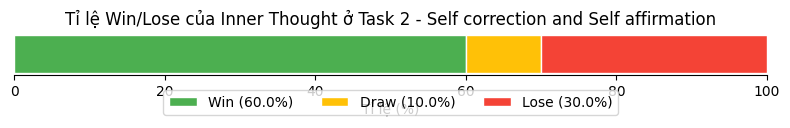

In [60]:
task2_res = draw(task2, "Tỉ lệ Win/Lose của Inner Thought ở Task 2 - Self correction and Self affirmation")

In [57]:
# Task 2

with open(r"task3_win_lose.json", "r", encoding="utf-8") as f:
    task3 = json.load(f)

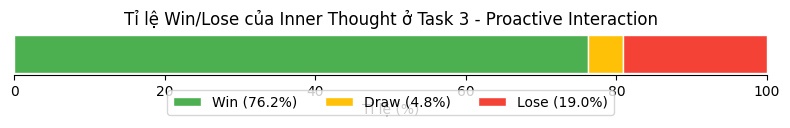

In [61]:
task3_res = draw(task3, "Tỉ lệ Win/Lose của Inner Thought ở Task 3 - Proactive Interaction")

In [62]:
# Task 4

with open(r"task4_win_lose.json", "r", encoding="utf-8") as f:
    task4 = json.load(f)

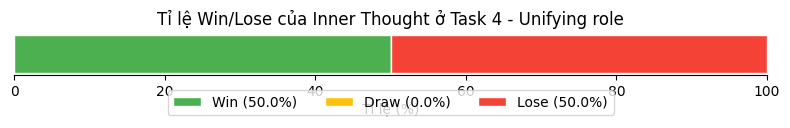

In [63]:
task4_res = draw(task4, "Tỉ lệ Win/Lose của Inner Thought ở Task 4 - Unifying role")

In [65]:
overall_wins = task2_res+task3_res+task4_res

In [66]:
len(overall_wins)

61

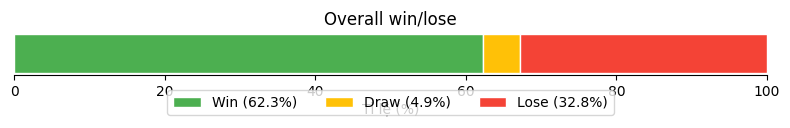

In [67]:
result_counts = Counter(overall_wins)
values = [result_counts[1], result_counts[0], result_counts[-1]]
labels = ['Win', 'Draw', 'Lose']
colors = ['#4CAF50', '#FFC107', '#F44336']  # xanh lá, vàng, đỏ

# Tính phần trăm
total = sum(values)
percentages = [v / total * 100 for v in values]

# Tạo biểu đồ stacked horizontal bar
fig, ax = plt.subplots(figsize=(8, 1.5))
left = 0
for i in range(len(labels)):
    ax.barh(0, percentages[i], left=left, color=colors[i], edgecolor='white', label=f"{labels[i]} ({percentages[i]:.1f}%)")
    left += percentages[i]

# Tùy chỉnh hiển thị
ax.set_xlim(0, 100)
ax.set_yticks([])
ax.set_xlabel('Tỉ lệ (%)')
ax.set_title(f'Overall win/lose')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
ax.spines[['top', 'right', 'left']].set_visible(False)

plt.tight_layout()
plt.show()